# Insights

## Data Loading and Preprocessing

In this section, we load the dataset and preprocess it by renaming columns and converting date columns to datetime format.

## Function Definitions

### `see` Function

The `see` function filters the data based on the ATC code, calculates event intervals, and performs various analyses including ECDF, KDE, and K-means clustering.

### `see_assumption` Function

The `see_assumption` function analyzes the data by calculating the duration between events and visualizing the results using scatter plots.

## Example Usage

We use the `see` and `see_assumption` functions to analyze the data for two different ATC codes: "A02BC02" and "A09AA02".

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.distributions.empirical_distribution import ECDF

# Load the dataset
data = pd.read_csv("med_events.csv")

# Rename columns to match the R code
data.columns = ["pnr", "eksd", "dur_original", "perday", "ATC", "CATEGORY_L1", "CATEGORY_L2"]
data['eksd'] = pd.to_datetime(data['eksd'])

In [21]:
def see(arg1):
    C09CA01 = data[data['ATC'] == arg1].copy()
    print(f"Filtered data size: {C09CA01.shape}")
    Drug_see_p0 = C09CA01.copy()
    Drug_see_p1 = C09CA01.copy()
    Drug_see_p1 = Drug_see_p1.sort_values(by=['pnr', 'eksd'])
    Drug_see_p1['prev_eksd'] = Drug_see_p1.groupby('pnr')['eksd'].shift(1)
    Drug_see_p1 = Drug_see_p1.dropna()
    Drug_see_p1 = Drug_see_p1.groupby('pnr').apply(lambda x: x.sample(1)).reset_index(drop=True)
    Drug_see_p1 = Drug_see_p1[['pnr', 'eksd', 'prev_eksd']]
    Drug_see_p1['event_interval'] = (Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']).dt.days
    print(f"Event interval data size: {Drug_see_p1.shape}")
    per = ECDF(Drug_see_p1['event_interval'])
    x = Drug_see_p1['event_interval']
    y = per(x)
    dfper = pd.DataFrame({'x': x, 'y': y})
    
    # Retain the 20% of the ECDF
    dfper = dfper[dfper['y'] <= 0.8]
    print(f"Filtered ECDF data size: {dfper.shape}")
    ni = dfper['x'].max()
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='x', y='y', data=dfper)
    plt.title("80% ECDF")
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=x, y=y)
    plt.title("100% ECDF")
    plt.show()
    
    m1 = Drug_see_p1['pnr'].value_counts()
    plt.figure()
    m1.plot(kind='bar')
    plt.show()
    
    Drug_see_p2 = Drug_see_p1[Drug_see_p1['event_interval'] <= ni]
    print(f"Filtered event interval data size: {Drug_see_p2.shape}")
    
    # Filter out zero or negative event intervals
    Drug_see_p2 = Drug_see_p2[Drug_see_p2['event_interval'] > 0]
    
    x1, y1 = [], []  # Initialize x1 and y1 with empty arrays
    if len(Drug_see_p2) > 1:
        d = gaussian_kde(np.log(Drug_see_p2['event_interval']))
        x1 = np.linspace(min(np.log(Drug_see_p2['event_interval'])), max(np.log(Drug_see_p2['event_interval'])), 1000)
        y1 = d(x1)
        plt.figure()
        sns.scatterplot(x=x1, y=y1)
        plt.title("Log(event interval)")
        plt.show()
    else:
        print("Not enough data points for KDE")
    
    if len(x1) > 0 and len(y1) > 0:
        a = pd.DataFrame({'x': x1, 'y': y1})
        a = (a - a.mean()) / a.std()
        
        # Silhouette Score
        kmeans = KMeans(n_clusters=2, random_state=1234)
        kmeans.fit(a)
        silhouette_avg = silhouette_score(a, kmeans.labels_)
        print(f'Silhouette Score: {silhouette_avg}')
        
        # K-means Clustering
        kmeans = KMeans(n_clusters=2, random_state=1234)
        dfper['cluster'] = kmeans.fit_predict(dfper[['x']])
        print(dfper.groupby('cluster')['x'].describe())
        
        ni2 = dfper.groupby('cluster')['x'].min().reset_index()
        ni3 = dfper.groupby('cluster')['x'].max().reset_index()
        ni4 = dfper.groupby('cluster')['x'].median().reset_index()
        ni2.columns = ['Cluster', 'Minimum']
        ni3.columns = ['Cluster', 'Maximum']
        ni4.columns = ['Cluster', 'Median']
        nif = pd.merge(ni2, ni3, on='Cluster')
        nif = pd.merge(nif, ni4, on='Cluster')
        
        results = pd.merge(Drug_see_p1, nif, left_on='pnr', right_on='Cluster', how='left')
        results['Final_cluster'] = np.where((results['event_interval'] >= results['Minimum']) & (results['event_interval'] <= results['Maximum']), results['Cluster'], np.nan)
        results = results.dropna(subset=['Final_cluster'])
        results['Median'] = np.exp(results['Median'])
        results = results[['pnr', 'Median', 'Cluster']]
        
        if not results['Cluster'].empty:
            t1 = results['Cluster'].value_counts().idxmax()
            t1 = pd.DataFrame({'Cluster': [t1]})
            t1_merged = pd.merge(t1, results, on='Cluster')
            t1_merged = t1_merged.iloc[0]
            t1 = t1_merged[['Cluster']]
        else:
            t1 = pd.DataFrame({'Cluster': [0], 'Median': [0]})
        
        Drug_see_p1 = pd.merge(Drug_see_p1, results, on='pnr', how='left')
        Drug_see_p1['Median'] = Drug_see_p1['Median'].fillna(t1['Median'])
        Drug_see_p1['Cluster'] = Drug_see_p1['Cluster'].fillna(0)
        Drug_see_p1['event_interval'] = Drug_see_p1['event_interval'].astype(float)
        Drug_see_p1['test'] = round(Drug_see_p1['event_interval'] - Drug_see_p1['Median'], 1)
        
        Drug_see_p3 = Drug_see_p1[['pnr', 'Median', 'Cluster']]
        
        # Assign Duration
        Drug_see_p0 = pd.merge(Drug_see_p0, Drug_see_p3, on='pnr', how='left')
        Drug_see_p0['Median'] = Drug_see_p0['Median'].astype(float)
        Drug_see_p0['Median'] = Drug_see_p0['Median'].fillna(t1['Median'])
        Drug_see_p0['Cluster'] = Drug_see_p0['Cluster'].fillna(0)
    
    return Drug_see_p0

In [22]:
def see_assumption(arg1):
    arg1 = arg1.sort_values(by=['pnr', 'eksd'])
    arg1['prev_eksd'] = arg1.groupby('pnr')['eksd'].shift(1)
    Drug_see2 = arg1.copy()
    Drug_see2 = Drug_see2.sort_values(by=['pnr', 'eksd'])
    Drug_see2['p_number'] = Drug_see2.groupby('pnr').cumcount() + 1
    Drug_see2 = Drug_see2[Drug_see2['p_number'] >= 2]
    Drug_see2 = Drug_see2[['pnr', 'eksd', 'prev_eksd', 'p_number']]
    Drug_see2['Duration'] = (Drug_see2['eksd'] - Drug_see2['prev_eksd']).dt.days
    Drug_see2['p_number'] = Drug_see2['p_number'].astype(str)
    
    print(f"Data for scatter plot: {Drug_see2.shape}")
    print(Drug_see2.head())  # Print first few rows of the data being plotted
    plt.figure()
    sns.scatterplot(x='p_number', y='Duration', data=Drug_see2)
    plt.show()
    
    medians_of_medians = Drug_see2.groupby('pnr')['Duration'].median().reset_index()
    print(f"Medians of medians: {medians_of_medians.shape}")
    print(medians_of_medians.head())  # Print first few rows of the medians of medians
    plt.figure()
    sns.scatterplot(x='p_number', y='Duration', data=Drug_see2)
    plt.axhline(y=medians_of_medians['Duration'].median(), color='red', linestyle='--')
    plt.show()

Filtered data size: (3, 7)
Event interval data size: (1, 4)
Filtered ECDF data size: (0, 2)


C:\Users\Eiji\AppData\Local\Temp\ipykernel_17124\211093685.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Drug_see_p1 = Drug_see_p1.groupby('pnr').apply(lambda x: x.sample(1)).reset_index(drop=True)


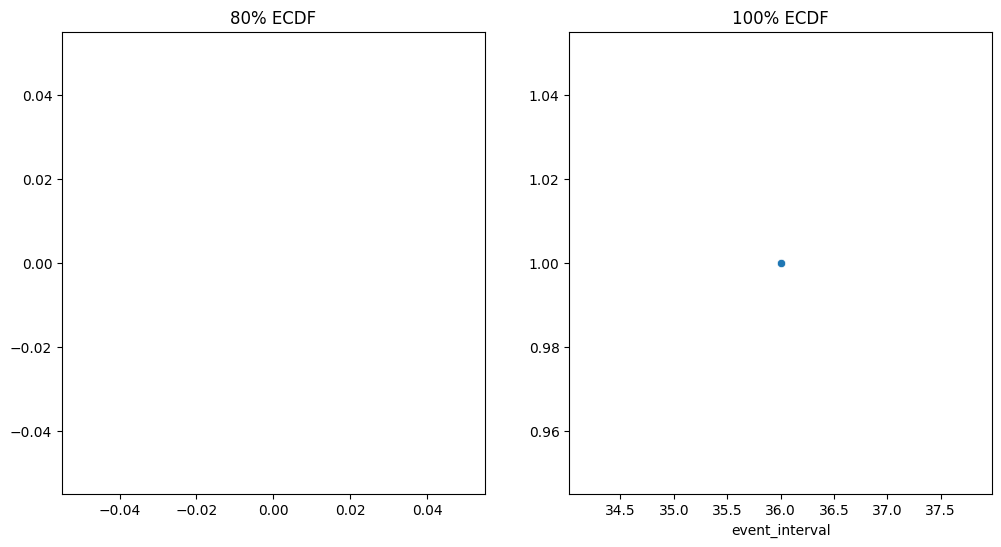

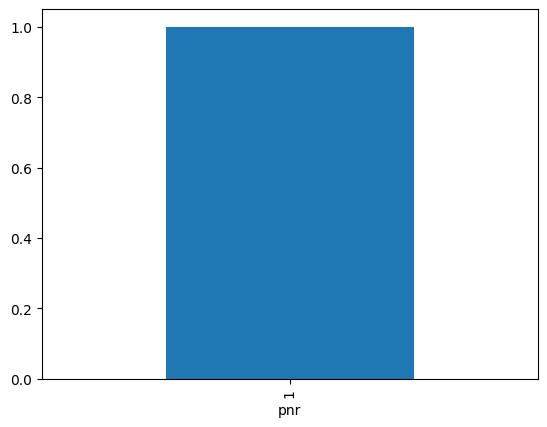

Filtered event interval data size: (0, 4)
Not enough data points for KDE
Filtered data size: (251, 7)
Event interval data size: (13, 4)
Filtered ECDF data size: (10, 2)


C:\Users\Eiji\AppData\Local\Temp\ipykernel_17124\211093685.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Drug_see_p1 = Drug_see_p1.groupby('pnr').apply(lambda x: x.sample(1)).reset_index(drop=True)


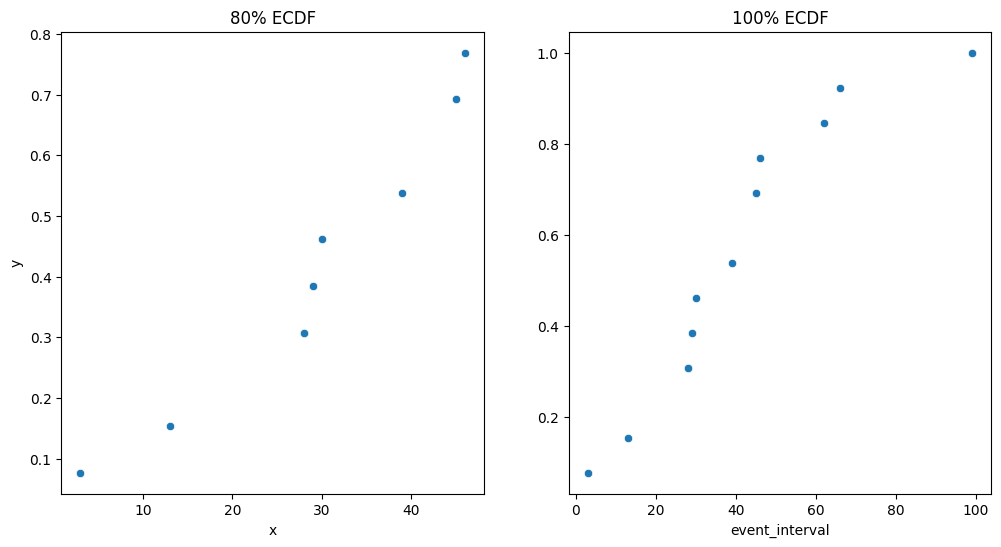

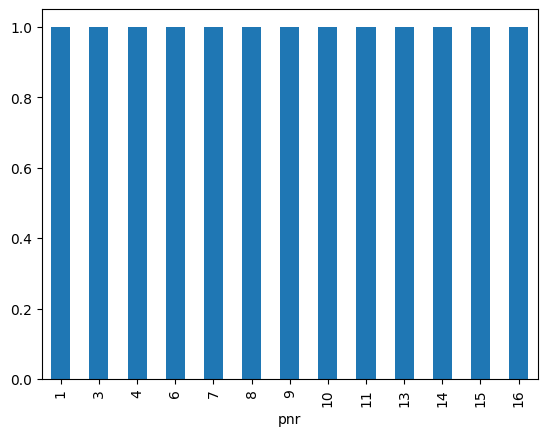

Filtered event interval data size: (10, 4)


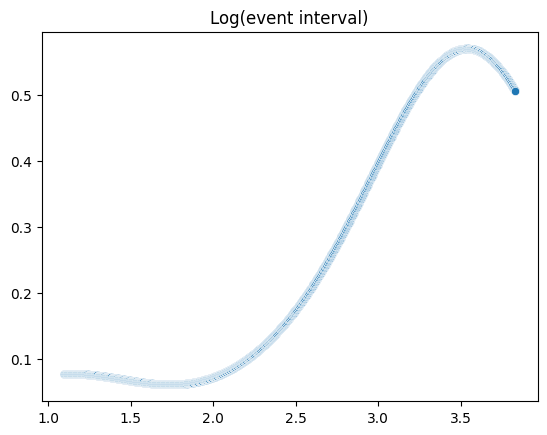

Silhouette Score: 0.6747610963718039
         count       mean        std   min    25%   50%    75%   max
cluster                                                             
0          6.0  21.833333  11.196726   3.0  16.75  28.0  28.75  30.0
1          4.0  43.750000   3.201562  39.0  43.50  45.0  45.25  46.0
Data for scatter plot: (2, 5)
   pnr       eksd  prev_eksd p_number  Duration
1    1 2058-06-03 2057-09-04        2       272
2    1 2058-07-09 2058-06-03        3        36


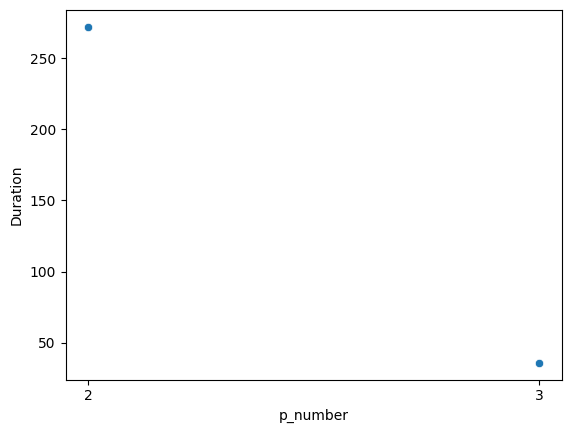

Medians of medians: (1, 2)
   pnr  Duration
0    1     154.0


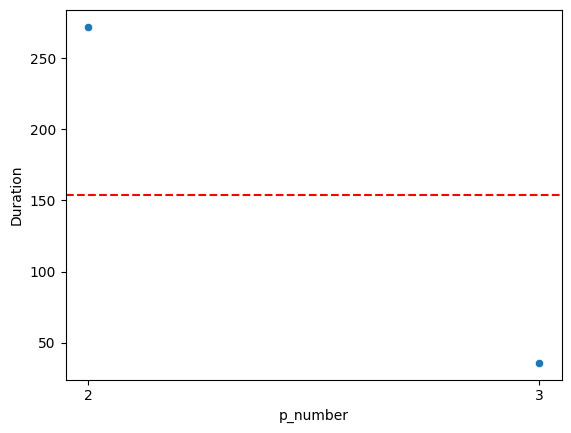

Data for scatter plot: (237, 5)
   pnr       eksd  prev_eksd p_number  Duration
1    1 2056-12-10 2056-10-09        2        62
2    1 2057-02-12 2056-12-10        3        64
3    1 2057-02-23 2057-02-12        4        11
4    1 2057-02-24 2057-02-23        5         1
5    1 2057-05-02 2057-02-24        6        67


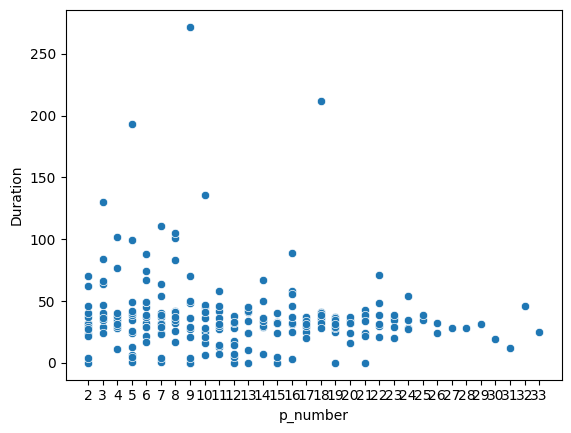

Medians of medians: (13, 2)
   pnr  Duration
0    1      63.0
1    3      45.0
2    4      36.5
3    6      99.0
4    7      33.5


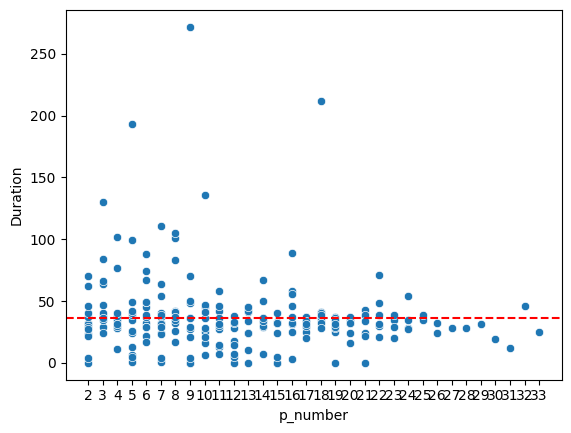

In [23]:
medA = see("A02BC02")
medB = see("A09AA02")

see_assumption(medA)
see_assumption(medB)